# TP9 (Student version): link prediction using rankings

## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472

We can use the following libraries.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import sys
import random
import time
import copy
import itertools
print(sys.version)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


## Data

The dataset that we use is an old online social network of hamster lovers called *hamsterer*. The links of the dataset are friendship links among users. Download from Moodle the datasets :

- hamsterer_train.txt , this is the training dataset that we use to order pairs of nodes (roughly 90% of the full data)

- hamsterer_test.txt , this is the test dataset that is the set of "missing links" that we are supposed to discover using a link prediction method (roughly 10% of the data).

You can load both datasets as dictionary of lists as usual.

In [2]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

In [3]:
filename = 'hamsterer_train.txt'
hamsterer_train_graph = load_graph(filename)

In [4]:
filename = 'hamsterer_test.txt'
hamsterer_test_graph = load_graph(filename)

## Exercise 1: Features for link prediction

### Question 1

1) Make a function that, given a pair of nodes $ (i,j) $ in the network, computes the number of Common Neighbors (CN) between these two nodes.

2) Do the same thing for the preferential attachment index of $ (i,j) $, we remind that
$$ PA(i,j) = |N(i)|.|N(j)| $$

3) Do the same thing for the Adamic-Adar index of $ (i,j) $, we remind that
$$ AA(i,j) = \sum _{k \in N(i) \cap N(j)} \frac{1}{log(d_k)} $$

where $ N(i) $ is the neighborhood of node $i$ and $ d_k $ the degree of node $k$.

In [5]:
def common_neighbors(graph, i, j):
    neighbors_i = set(graph[i])
    neighbors_j = set(graph[j])
    return len(neighbors_i.intersection(neighbors_j))

In [6]:
def preferential_attachment(graph, i, j):
    degree_i = len(graph[i])
    degree_j = len(graph[j])
    return degree_i * degree_j

In [7]:
def adamic_adar(graph, i, j):
    neighbors_i = set(graph[i])
    neighbors_j = set(graph[j])
    common_neighbors = neighbors_i.intersection(neighbors_j)
    
    adamic_adar_index = 0
    for k in common_neighbors:
        degree_k = len(graph[k])
        adamic_adar_index += 1 / math.log(degree_k) if degree_k > 1 else 0  # Avoid division by zero
    
    return adamic_adar_index

In [8]:
# Example usage
i, j = '490', '211'  # Assuming node labels are strings in the graph

# Common Neighbors
cn = common_neighbors(hamsterer_train_graph, i, j)
print(f"Common Neighbors between nodes {i} and {j}: {cn}")

# Preferential Attachment
pa = preferential_attachment(hamsterer_train_graph, i, j)
print(f"Preferential Attachment between nodes {i} and {j}: {pa}")

# Adamic-Adar Index
aa = adamic_adar(hamsterer_train_graph, i, j)
print(f"Adamic-Adar Index between nodes {i} and {j}: {aa}")

Common Neighbors between nodes 490 and 211: 4
Preferential Attachment between nodes 490 and 211: 1512
Adamic-Adar Index between nodes 490 and 211: 0.8197035060018205


### Question 2

Select 10000 pairs of nodes randomly in the training dataset.

1) Plot the corresponding data points in a $AA$ vs $PA$ space with a red point if the edge exists and a blue point if it doesn't (as in the course). For readability purposes, you should use logarithmic scales.

2) Can you compare the number of unconnected pairs in the plot to the number of connected pairs? What is the name of the phenomenon that we have described in the course and that this plot shows?

3) Do you think that a $k$-nearest neighbor method would work well with these features? Explain why briefly?

In [9]:
def select_random_pairs(graph, num_pairs):
    nodes = list(graph.keys())    
    pairs = []
    
    for _ in range(num_pairs):
        pair = (random.choice(nodes), random.choice(nodes))
        pairs.append(pair)

    return pairs

In [10]:
# Adjust the number of pairs if needed
num_pairs = 10000  # or any other value less than half of the number of nodes
random_pairs = select_random_pairs(hamsterer_train_graph, num_pairs)

In [11]:
# Step 2: Compute AA and PA indices for each pair of nodes
features = []
labels = []

for pair in random_pairs:
    i, j = pair
    aa = adamic_adar(hamsterer_train_graph, i, j)
    pa = preferential_attachment(hamsterer_train_graph, i, j)
    features.append([aa, pa])
    labels.append(1 if (j in hamsterer_train_graph[i]) or (i in hamsterer_train_graph[j]) else 0)

features = np.array(features)
labels = np.array(labels)

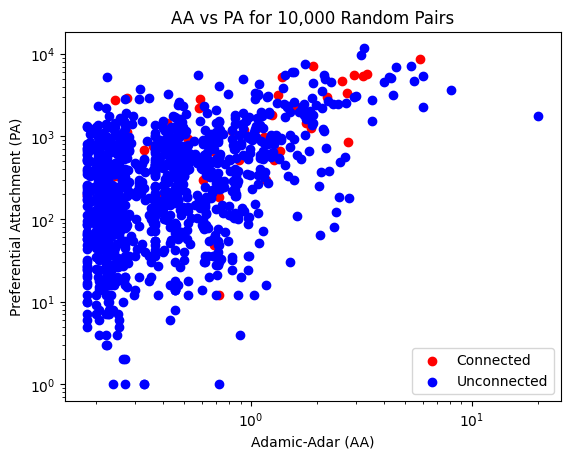

In [12]:
# Step 3: Plot the points
connected_pairs = labels == 1
unconnected_pairs = labels == 0

plt.scatter(features[connected_pairs, 0], features[connected_pairs, 1], color='red', label='Connected')
plt.scatter(features[unconnected_pairs, 0], features[unconnected_pairs, 1], color='blue', label='Unconnected')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Adamic-Adar (AA)')
plt.ylabel('Preferential Attachment (PA)')
plt.title('AA vs PA for 10,000 Random Pairs')
plt.legend()
plt.show()

In [13]:
# Step 4: Analyze the plot
num_connected_pairs = connected_pairs.sum()
num_unconnected_pairs = unconnected_pairs.sum()
print(f"Number of connected pairs: {num_connected_pairs}")
print(f"Number of unconnected pairs: {num_unconnected_pairs}")

Number of connected pairs: 65
Number of unconnected pairs: 9935


In [14]:
# Step 5: Discuss the k-NN method
# k-NN could work well with these features as they capture some aspects of network structure.
# The plot shows that connected pairs tend to cluster together, which is a phenomenon known as
# "homophily" or "assortativity" in network science.
# The k-NN method might work well, but experimenting with different values of k and evaluating
# performance on a validation set is recommended.

## Exercise 2: Ranking to predict links

### Question 3

Write functions that allows to rank pairs of nodes by decreasing score for the four scores computed above: $CN$, $PA$ and $AA$.

**Warning**: even if our dataset is rather small, we need to optimize this computation, otherwise it will be too long: we only compute the scores of pairs at distance exactly 2 (because if the distance is 1 these nodes are already connected and if the distance is > 2, they share no neighbors and thus their AA and CN scores are 0).


In [15]:
def rank_pairs_by_score(graph):
    nodes = list(graph.keys())
    pairs = list(itertools.combinations(nodes, 2))

    # Compute scores for each pair
    scores = []
    for pair in pairs:
        i, j = pair
        cn = common_neighbors(graph, i, j)
        pa = preferential_attachment(graph, i, j)
        aa = adamic_adar(graph, i, j)
        scores.append((pair, cn, pa, aa))

    # Rank pairs by scores in decreasing order
    ranked_pairs = sorted(scores, key=lambda x: (x[1], x[2], x[3]), reverse=True)

    return ranked_pairs

In [16]:
# Example usage
ranked_pairs = rank_pairs_by_score(hamsterer_train_graph)

# Print top 10 ranked pairs
print("Top 10 Ranked Pairs:")
for pair, cn, pa, aa in ranked_pairs[:10]:
    print(f"Pair: {pair}, CN: {cn}, PA: {pa}, AA: {aa}")

Top 10 Ranked Pairs:
Pair: ('237', '238'), CN: 164, PA: 49776, AA: 62.15509530467796
Pair: ('3', '177'), CN: 94, PA: 12769, AA: 31.004380758889603
Pair: ('45', '44'), CN: 91, PA: 19431, AA: 36.327504599714985
Pair: ('176', '3'), CN: 89, PA: 12882, AA: 30.053989663706034
Pair: ('45', '47'), CN: 87, PA: 13716, AA: 33.52329831965077
Pair: ('176', '177'), CN: 87, PA: 12882, AA: 28.86855224607585
Pair: ('178', '177'), CN: 86, PA: 10961, AA: 28.44014267337406
Pair: ('46', '47'), CN: 85, PA: 13068, AA: 31.807632001699492
Pair: ('3', '178'), CN: 85, PA: 10961, AA: 28.67410368850092
Pair: ('46', '45'), CN: 83, PA: 15367, AA: 32.73384967473192


In [17]:
def rank_pairs_by_score_v2(graph, method):
    nodes = list(graph.keys())
    pairs = list(itertools.combinations(nodes, 2))

    # Compute scores for each pair based on the specified method
    scores = []
    for pair in pairs:
        i, j = pair
        if method == 'CN':
            score = common_neighbors(graph, i, j)
        elif method == 'PA':
            score = preferential_attachment(graph, i, j)
        elif method == 'AA':
            score = adamic_adar(graph, i, j)
        else:
            raise ValueError("Invalid method. Choose from 'CN', 'PA', or 'AA'.")
        
        scores.append((pair, score))

    # Rank pairs by scores in decreasing order
    ranked_pairs = sorted(scores, key=lambda x: x[1], reverse=True)

    return ranked_pairs

In [18]:
# Example usage
ranked_pairs_CN = rank_pairs_by_score_v2(hamsterer_train_graph, "CN")

In [19]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with CN score:")
for pair, cn in ranked_pairs_CN[:10]:
    print(f"Pair: {pair}, CN: {cn}")

Top 10 Ranked Pairs with CN score:
Pair: ('237', '238'), CN: 164
Pair: ('3', '177'), CN: 94
Pair: ('45', '44'), CN: 91
Pair: ('176', '3'), CN: 89
Pair: ('176', '177'), CN: 87
Pair: ('45', '47'), CN: 87
Pair: ('178', '177'), CN: 86
Pair: ('3', '178'), CN: 85
Pair: ('46', '47'), CN: 85
Pair: ('176', '178'), CN: 83


In [20]:
# Example usage
ranked_pairs_PA = rank_pairs_by_score_v2(hamsterer_train_graph, "PA")

In [21]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with PA score:")
for pair, pa in ranked_pairs_PA[:10]:
    print(f"Pair: {pair}, PA: {pa}")

Top 10 Ranked Pairs with PA score:
Pair: ('237', '238'), PA: 49776
Pair: ('237', '44'), PA: 37332
Pair: ('237', '168'), PA: 32940
Pair: ('237', '137'), PA: 32696
Pair: ('237', '169'), PA: 31232
Pair: ('44', '238'), PA: 31212
Pair: ('237', '45'), PA: 30988
Pair: ('237', '46'), PA: 29524
Pair: ('237', '176'), PA: 27816
Pair: ('237', '3'), PA: 27572


In [22]:
# Example usage
ranked_pairs_AA = rank_pairs_by_score_v2(hamsterer_train_graph, "AA")

In [23]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with AA score:")
for pair, aa in ranked_pairs_AA[:10]:
    print(f"Pair: {pair}, AA: {aa}")

Top 10 Ranked Pairs with AA score:
Pair: ('237', '238'), AA: 62.15509530467796
Pair: ('45', '44'), AA: 36.327504599714985
Pair: ('65', '66'), AA: 35.56144196775982
Pair: ('169', '87'), AA: 35.09505631677845
Pair: ('45', '47'), AA: 33.52329831965077
Pair: ('46', '45'), AA: 32.73384967473192
Pair: ('46', '47'), AA: 31.807632001699492
Pair: ('3', '177'), AA: 31.004380758889603
Pair: ('47', '44'), AA: 30.16485288120493
Pair: ('176', '3'), AA: 30.053989663706034


### Question 4

1) For a given number of predictions $T$ on a given ranking, make a function that computes the Precision and Recall for this prediction. We remind that

$$ Pr = \frac{\# tp}{\# predictions}$$ 

$$ Rc = \frac{\# tp}{\# connected \ pairs \ to \ discover} $$

2) Try the following values for $T$: [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000] and plot the corresponding curve in the recall-precision space for the *CN*, *PA* and *AA* index and also for a random ordering. 

3) Which index seems to be the most efficient with these data? Does it correspond to the example of the course? Do you see any explanation for that?

In [24]:
# Define the precision-recall computation function
def compute_precision_recall(predictions, connected_pairs_set):
    tp = len(set(predictions).intersection(connected_pairs_set))
    precision = tp / len(predictions) if len(predictions) > 0 else 0
    recall = tp / len(connected_pairs_set)
    return precision, recall

In [25]:
# Set of connected pairs to discover (replace with your actual connected pairs)
connected_pairs_set = set(tuple(pair) for pair in hamsterer_test_graph.keys())

# Try different values for T
T_values = [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]

# Lists to store precision and recall values for each method
precision_CN, recall_CN = [], []
precision_PA, recall_PA = [], []
precision_AA, recall_AA = [], []
precision_random, recall_random = [], []

In [26]:
# Compute precision and recall for each method and each T
for T in T_values:
    # Generate rankings for Common Neighbors
    ranked_pairs_CN = rank_pairs_by_score_v2(hamsterer_train_graph, 'CN')
    predictions_CN = [pair for pair, _ in ranked_pairs_CN[:T]]
    precision, recall = compute_precision_recall(predictions_CN, connected_pairs_set)
    precision_CN.append(precision)
    recall_CN.append(recall)

    # Generate rankings for Preferential Attachment
    ranked_pairs_PA = rank_pairs_by_score_v2(hamsterer_train_graph, 'PA')
    predictions_PA = [pair for pair, _ in ranked_pairs_PA[:T]]
    precision, recall = compute_precision_recall(predictions_PA, connected_pairs_set)
    precision_PA.append(precision)
    recall_PA.append(recall)

    # Generate rankings for Adamic-Adar
    ranked_pairs_AA = rank_pairs_by_score_v2(hamsterer_train_graph, 'AA')
    predictions_AA = [pair for pair, _ in ranked_pairs_AA[:T]]
    precision, recall = compute_precision_recall(predictions_AA, connected_pairs_set)
    precision_AA.append(precision)
    recall_AA.append(recall)

    # Generate random ordering
    random_pairs = select_random_pairs(hamsterer_train_graph, T)
    predictions_random = random_pairs
    precision, recall = compute_precision_recall(predictions_random, connected_pairs_set)
    precision_random.append(precision)
    recall_random.append(recall)

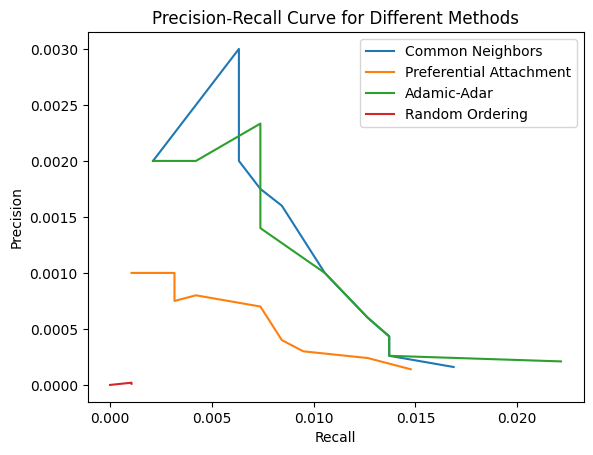

In [27]:
# Plot the precision-recall curves
plt.plot(recall_CN, precision_CN, label='Common Neighbors')
plt.plot(recall_PA, precision_PA, label='Preferential Attachment')
plt.plot(recall_AA, precision_AA, label='Adamic-Adar')
plt.plot(recall_random, precision_random, label='Random Ordering')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Methods')
plt.legend()
plt.show()